# Handling Missing values

### Filling missing values manually

In [1]:
def fill_num_values(dataset, mode="mean"):
    import pandas as pd
    num_cols = list(dataset.select_dtypes(include="float64")) + list(dataset.select_dtypes(include="int64")) 
    for col in num_cols:
        if dataset[col].isnull().sum() > 0:
            if mode=="mean":
                dataset[col].fillna(dataset[col].mean(), inplace = True)
            elif mode=="median":
                dataset[col].fillna(dataset[col].median(), inplace = True)
            else:
                dataset[col].fillna(dataset[col].mode()[0], inplace = True)
    return dataset

In [2]:
def fill_col(dataset, col, mode="mean"):
    if dataset[col].isnull().sum() > 0:
        if mode=="mean":
            dataset[col].fillna(dataset[col].mean(), inplace = True)
        elif mode=="median":
            dataset[col].fillna(dataset[col].median(), inplace = True)
        else:
            dataset[col].fillna(dataset[col].mode()[0], inplace = True)
    return dataset

In [3]:
def fill_obj_values(dataset):
    import pandas as pd
    obj_cols = dataset.select_dtypes("object")
    for col in obj_cols:
        if dataset[col].isnull().sum() > 0:
            dataset[col].fillna(dataset[col].mode()[0], inplace=True)
    return dataset

### Filling missing values using sklearn

In [4]:
def fill_sklearn(dataset, strategy="mean"):
    from sklearn.impute import SimpleImputer
    import pandas as pd
    #num_cols
    num_cols = list(dataset.select_dtypes(include="float64")) + list(dataset.select_dtypes(include="int64"))
    imputer = SimpleImputer(strategy = strategy)
    updated = pd.DataFrame(imputer.fit_transform(dataset[num_cols]), columns=num_cols)
    dataset.update(updated)
    #obj_cols
    obj_cols = list(dataset.select_dtypes(include="object"))
    imputer = SimpleImputer(strategy="most_frequent")
    updated = pd.DataFrame(imputer.fit_transform(dataset[obj_cols]), columns=obj_cols)
    dataset.update(updated)

    return dataset

# Encoding

### OneHotEncoding

In [5]:
def one_hot_encode(dataset, col: str):
    from sklearn.preprocessing import OneHotEncoder
    import pandas as pd
    ohe = OneHotEncoder(drop="first")
    dataset[col+"_ohe"] = ohe.fit_transform(dataset[[col]]).toarray()

    return dataset


### LabelEncoding

In [6]:
def label_encode(dataset, col: str):
    from sklearn.preprocessing import LabelEncoder
    import pandas as pd
    le = LabelEncoder()
    le.fit(dataset[col])
    dataset[col+"_le"] = pd.DataFrame(le.transform(dataset[[col]]))
    
    return dataset


### OrdinalEncoding

In [7]:
def ordinal_encode(dataset, col: str, ord_data: list):
    from sklearn.preprocessing import OrdinalEncoder
    import pandas as pd
    oe = OrdinalEncoder(categories=[ord_data])
    oe.fit(dataset[[col]])
    dataset[col+"_oe"] = pd.DataFrame(oe.transform(dataset[[col]]))

    return dataset

### Mapping

In [8]:
def map_encode(dataset, col: str, ord_data:dict):
    import pandas as pd
    dataset[col+"_map"] = dataset[col].map(ord_data)

    return dataset

# Graph

In [56]:
def plot_graph(initial, final, col, mode="box"):
    import warnings
    warnings.filterwarnings('ignore')  
    import matplotlib.pyplot as plt
    import seaborn as sns
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    plt.title("Before")
    if mode == "box":
        sns.boxplot(x=col, data= initial)
    else:
        #sns.histplot(x=col, data=initial, kde=True, element='step')
        sns.distplot(initial[col])
        sns.despine()

    plt.subplot(1, 2, 2)
    plt.title("After")
    if mode == "box":
        sns.boxplot(x=col, data= final)
    else:
        #sns.histplot(x=col, data=final, kde=True, element='step')
        sns.distplot(final[col])
        sns.despine()


    plt.show()

# Outlier Elimination

### IQR

In [10]:
def outlier_iqr(dataset, col, mode):
    import pandas as pd
    q1 = dataset[col].quantile(0.25)
    q3 = dataset[col].quantile(0.75)
    IQR = q3-q1
    min_range = q1 - 1.5*IQR
    max_range = q3 + 1.5*IQR
    print(f'Min: {min_range}, Max: {max_range}')
    initial = dataset
    dataset = dataset[(dataset[col]>=min_range) & (dataset[col]<=max_range)]
    plot_graph(initial, dataset, col, mode)

    return dataset

### Z-score



In [11]:
def outlier_zscore(dataset, col, mode):
    MEAN = dataset[col].mean()
    SD = dataset[col].std()
    dataset["z_score"] = (dataset[col]-MEAN)/SD
    initial = dataset[[col]]
    dataset = dataset[(dataset["z_score"]>-3) & (dataset["z_score"]<3)]
    plot_graph(initial, dataset, col, mode)

    return dataset

### (MIN and MAX) Normal-Distrubution

In [12]:
def outlier_normal(dataset, col, mode):
    MEAN = dataset[col].mean()
    SD = dataset[col].std()
    min_range = MEAN - (3*SD)
    max_range = MEAN + (3*SD)
    print(f'Min: {min_range}, Max: {max_range}')
    initial = dataset[[col]]
    dataset = dataset[(dataset[col] >= min_range) & (dataset[col] <= max_range)]
    plot_graph(initial, dataset, col, mode)

    return dataset

# Feature Scaling

### Standardization

In [13]:
def standradize(dataset, col, mode, inplace=True):
    from sklearn.preprocessing import StandardScaler
    import pandas as pd
    ss = StandardScaler()
    ss.fit(dataset[[col]])
    if inplace==True:
        initial = dataset[[col]]
        dataset[col] = ss.transform(dataset[[col]])
        plot_graph(initial, dataset, col, mode)
    else:
        dataset[col+"_ss"] = ss.transform(dataset[[col]], inplace=True)
        print(f"New column added :'{col}+_ss'")
    return dataset

### Normalization (MinMaxScaling)

In [14]:
def min_max_scale(dataset, col, mode, inplace=True):
    from sklearn.preprocessing import MinMaxScaler
    mms = MinMaxScaler()
    mms.fit(dataset[[col]])
    if inplace==True:
        initial = dataset[[col]]
        dataset[col] = mms.transform(dataset[[col]])
        plot_graph(initial, dataset, col, mode)
    else:
        dataset[col+'_mms'] = mms.transform(dataset[[col]], inplace=True)
        print(f"New column added: '{col}+_mms")
    return dataset

# Remove Duplicates

In [15]:
def remove_duplicates(dataset):
    initial = dataset
    dataset.drop_duplicates()
    count = ((initial.shape[0]-dataset.shape[0])/initial.shape[0])*100
    if count > 10:
        print("Dataset isn't good enough")
    else:
        return dataset

# Function Transformation

In [57]:
def function_transform(dataset, col, funct, inplace=True):
    from sklearn.preprocessing import FunctionTransformer
    import pandas as pd
    import numpy as np
    ft = FunctionTransformer(func=np.log1p)
    initial = dataset[[col]]
    ft.fit(dataset[[col]])
    if inplace==True:
        dataset[col] = pd.DataFrame(ft.transform(dataset[[col]]))
        plot_graph(initial, dataset, col, "dist")
    else:
        dataset[col+"_transformed"] = ft.transform(dataset[[col]], inplace=True)
        print(f"New column added: '{col}+_transformed'")
    return dataset

# Feature Selection

In [2]:
def feature_selection(model, x, y, k_limit:int, forward=True):
    import warnings
    from mlxtend.feature_selection import SequentialFeatureSelector
    warnings.filterwarnings('ignore')
    features = {}
    for limit in range(k_limit, 1, -1):
        fs = SequentialFeatureSelector(estimator=model,k_features=limit, forward=forward)
        fs.fit(x, y)
        features[fs.k_feature_names_] = float(fs.k_score_)
    max_score = max(features.values())
    features_selected = {}
    for selection in features.keys():
        if features[selection] == max_score:
            features_selected[selection] = max_score
    return features_selected

# Test

In [63]:
import pandas as pd
dataset = pd.read_csv("loan-train.csv")
dataset.head(3)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y


In [64]:
#dataset.isnull().sum()

In [65]:
dataset = fill_sklearn(dataset, strategy="mean")

In [66]:
dataset.shape

(614, 13)

Min: -7157.4993096454655, Max: 10399.990905699668


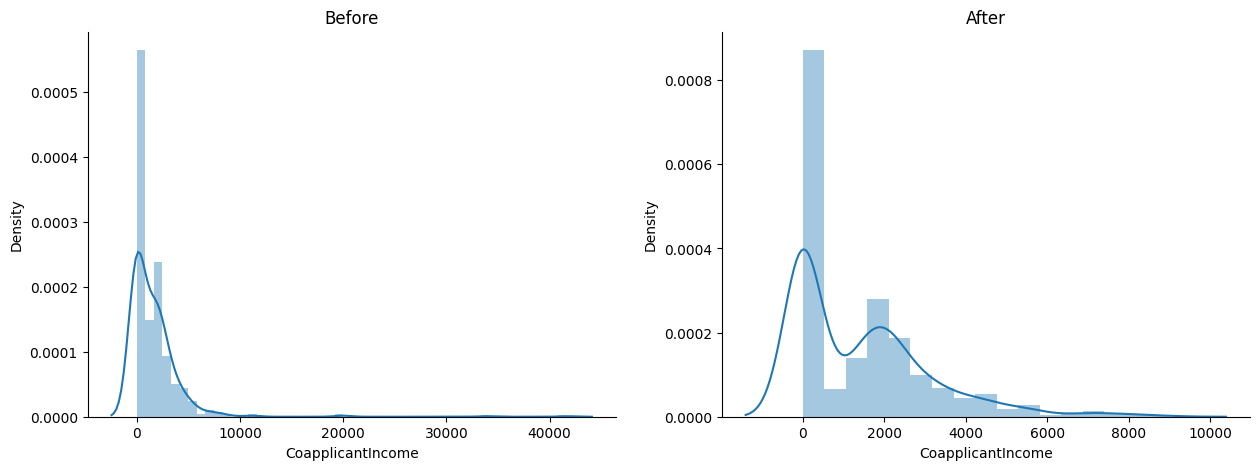

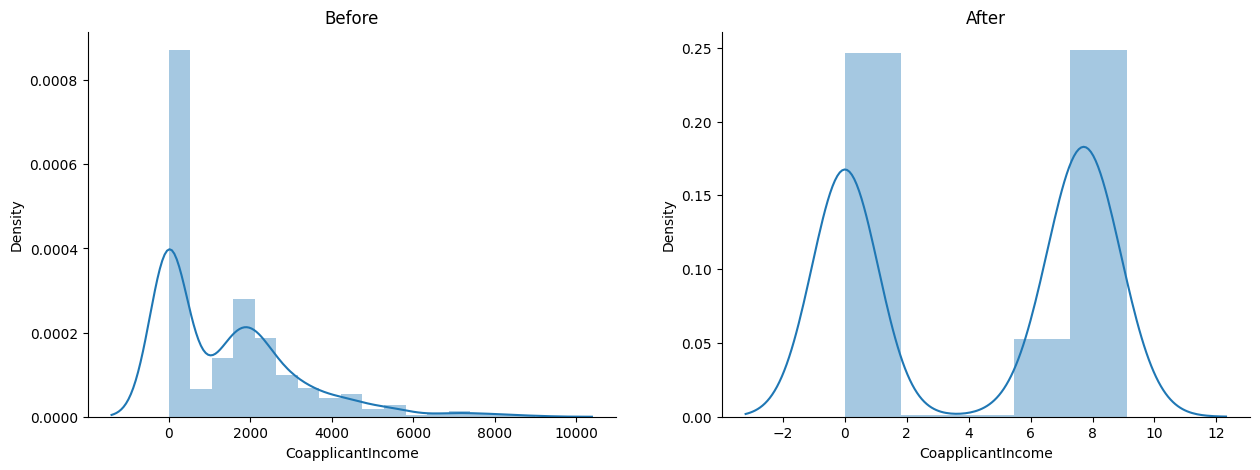

In [67]:
dataset = outlier_normal(dataset, "CoapplicantIncome", "dist")
import numpy as np
dataset = function_transform(dataset, "CoapplicantIncome", np.log1p)

In [21]:
dataset.shape

(614, 13)